In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#modeling
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

In [2]:
kiva = pd.read_csv('kivamix.csv')

In [3]:
kiva.shape

(419156, 35)

Variables of interest: 



In [4]:
#Drop unrequired columns
kiva['month'] = kiva['POSTED_TIME'].str[6:7]
kiva.drop(columns = ['LOAN_ID','LOAN_NAME', 'FUNDED_AMOUNT', 'DESCRIPTION', 'TOWN_NAME', 'CURRENCY_EXCHANGE_COVERAGE_RATE', 'CURRENCY', 'PARTNER_ID', 'PLANNED_EXPIRATION_TIME', 'DISBURSE_TIME', 'POSTED_TIME', 'RAISED_TIME', 'NUM_LENDERS_TOTAL', 'NUM_JOURNAL_ENTRIES', 'NUM_BULK_ENTRIES', 'BORROWER_NAMES', 'COUNTRY_NAME', 'CURRENCY_POLICY','year'], inplace=True)


In [5]:
kiva.shape

(419156, 17)

In [6]:
#Converting long text columns to length of words and count of characters
#Step1 is to drop nulls
kiva = kiva.drop(kiva[(kiva['DESCRIPTION_TRANSLATED'].isnull()==True)].index)
kiva = kiva.drop(kiva[(kiva['TAGS'].isnull()==True)].index)
kiva = kiva.drop(kiva[(kiva['LOAN_USE'].isnull()==True)].index)



In [7]:
#Step 2 is to update new columns
def word_len_count(column):
    word_count = len(column.split())
    return word_count

def char_len_count(column):
    char_count = column.replace(' ','')
    char_count = len(char_count[:])
    return char_count

kiva['word_count_DT'] = kiva['DESCRIPTION_TRANSLATED'].apply(word_len_count)
kiva['word_count_TAGS'] = kiva['TAGS'].apply(word_len_count)
kiva['word_count_LU'] = kiva['LOAN_USE'].apply(word_len_count)

kiva['char_count_DT'] = kiva['DESCRIPTION_TRANSLATED'].apply(char_len_count)
kiva['char_count_TAGS'] = kiva['TAGS'].apply(char_len_count)
kiva['char_count_LU'] = kiva['LOAN_USE'].apply(char_len_count)


In [8]:
kiva.head(2)

,ORIGINAL_LANGUAGE,DESCRIPTION_TRANSLATED,LOAN_AMOUNT,STATUS,IMAGE_ID,VIDEO_ID,ACTIVITY_NAME,SECTOR_NAME,LOAN_USE,COUNTRY_CODE,...,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,month,word_count_DT,word_count_TAGS,word_count_LU,char_count_DT,char_count_TAGS,char_count_LU
0,Spanish,The city of Portoviejo is located in the valle...,1075.0,1,2638561.0,NaN,Natural Medicines,Health,to purchase natural products.,EC,...,true,monthly,field_partner,1,192,5,4,924,36,26
1,English,"Lorna is a married woman, 39 years old with fi...",400.0,0,3108106.0,NaN,Personal Products Sales,Retail,"to purchase additional stocks of Avon, Natasha...",PH,...,true,monthly,field_partner,3,75,3,12,371,28,69


In [ ]:
kiva.drop(columns = ['DESCRIPTION_TRANSLATED', 'LOAN_USE', 'TAGS'], inplace=True)


In [11]:
kiva.head(2)

,ORIGINAL_LANGUAGE,LOAN_AMOUNT,STATUS,IMAGE_ID,VIDEO_ID,ACTIVITY_NAME,SECTOR_NAME,COUNTRY_CODE,LENDER_TERM,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,month,word_count_DT,word_count_TAGS,word_count_LU,char_count_DT,char_count_TAGS,char_count_LU
0,Spanish,1075.0,1,2638561.0,NaN,Natural Medicines,Health,EC,6.0,female,true,monthly,field_partner,1,192,5,4,924,36,26
1,English,400.0,0,3108106.0,NaN,Personal Products Sales,Retail,PH,14.0,female,true,monthly,field_partner,3,75,3,12,371,28,69


In [12]:
kiva.shape

(344588, 20)

In [13]:
kiva.isnull().sum()

ORIGINAL_LANGUAGE          0
LOAN_AMOUNT                0
STATUS                     0
IMAGE_ID                   0
VIDEO_ID              344447
ACTIVITY_NAME              0
SECTOR_NAME                0
COUNTRY_CODE              11
LENDER_TERM                0
BORROWER_GENDERS           0
BORROWER_PICTURED          0
REPAYMENT_INTERVAL         0
DISTRIBUTION_MODEL         0
month                      0
word_count_DT              0
word_count_TAGS            0
word_count_LU              0
char_count_DT              0
char_count_TAGS            0
char_count_LU              0
dtype: int64

In [14]:
fill_values = {'ORIGINAL_LANGUAGE' : 'MISSING', 'BORROWER_GENDERS' : 'MISSING', 'BORROWER_PICTURED' : 'MISSING', 'COUNTRY_CODE':'MISSING' }
kiva .fillna(value = fill_values, inplace=True)

In [15]:
kiva.isnull().sum()

ORIGINAL_LANGUAGE          0
LOAN_AMOUNT                0
STATUS                     0
IMAGE_ID                   0
VIDEO_ID              344447
ACTIVITY_NAME              0
SECTOR_NAME                0
COUNTRY_CODE               0
LENDER_TERM                0
BORROWER_GENDERS           0
BORROWER_PICTURED          0
REPAYMENT_INTERVAL         0
DISTRIBUTION_MODEL         0
month                      0
word_count_DT              0
word_count_TAGS            0
word_count_LU              0
char_count_DT              0
char_count_TAGS            0
char_count_LU              0
dtype: int64

In [16]:
#Mark whether Image and Video was provided
kiva['IMAGE_ID'] = np.where(kiva['IMAGE_ID'].isnull(), 0, 1)
kiva['VIDEO_ID'] = np.where(kiva['VIDEO_ID'].isnull(), 0, 1)

In [17]:
## Parse out borrower genders
kiva['FEM_COUNT'] = kiva['BORROWER_GENDERS'].str.count("female")
kiva['MALE_COUNT'] = kiva['BORROWER_GENDERS'].str.count("male")

In [18]:
kiva['MALE_COUNT'].value_counts()

1     290804
2       8030
3       7982
4       6486
5       6426
8       2799
6       2565
10      2494
7       2151
9       2094
11      1613
12      1491
15      1277
13      1256
14      1053
16      1003
17       733
20       661
18       574
19       540
21       406
22       343
23       308
25       256
24       236
26       196
30       141
27       139
28       113
29       103
31        67
32        37
35        35
34        33
33        32
37        23
38        20
36        16
40        10
41         7
39         6
42         6
43         6
44         6
50         4
45         2
48         2
49         1
46         1
47         1
Name: MALE_COUNT, dtype: int64

In [19]:
kiva.columns

Index(['ORIGINAL_LANGUAGE', 'LOAN_AMOUNT', 'STATUS', 'IMAGE_ID', 'VIDEO_ID',
       'ACTIVITY_NAME', 'SECTOR_NAME', 'COUNTRY_CODE', 'LENDER_TERM',
       'BORROWER_GENDERS', 'BORROWER_PICTURED', 'REPAYMENT_INTERVAL',
       'DISTRIBUTION_MODEL', 'month', 'word_count_DT', 'word_count_TAGS',
       'word_count_LU', 'char_count_DT', 'char_count_TAGS', 'char_count_LU',
       'FEM_COUNT', 'MALE_COUNT'],
      dtype='object')

In [20]:
kiva = kiva.drop(columns = ['BORROWER_GENDERS', 'BORROWER_PICTURED'])

In [21]:
kiva.dtypes

ORIGINAL_LANGUAGE      object
LOAN_AMOUNT           float64
STATUS                  int64
IMAGE_ID                int32
VIDEO_ID                int32
ACTIVITY_NAME          object
SECTOR_NAME            object
COUNTRY_CODE           object
LENDER_TERM           float64
REPAYMENT_INTERVAL     object
DISTRIBUTION_MODEL     object
month                  object
word_count_DT           int64
word_count_TAGS         int64
word_count_LU           int64
char_count_DT           int64
char_count_TAGS         int64
char_count_LU           int64
FEM_COUNT               int64
MALE_COUNT              int64
dtype: object

In [22]:
kiva.shape

(344588, 20)

In [24]:
catcols = ['ORIGINAL_LANGUAGE', 'ACTIVITY_NAME', 'SECTOR_NAME', 'COUNTRY_CODE', 'REPAYMENT_INTERVAL', 'DISTRIBUTION_MODEL', 'month']

for i in range(1,len(catcols)):
    print(kiva.groupby(catcols[i], dropna=False)['STATUS'].agg(['count', 'mean']))
    #print(pd.pivot_table(df, columns = totcols[i], aggfunc=np.count))

                    count      mean
ACTIVITY_NAME                      
Adult Care              3  1.000000
Agriculture         11207  0.749353
Air Conditioning       16  1.000000
Animal Sales         4121  0.801747
Aquaculture           250  0.920000
...                   ...       ...
Water Distribution    246  0.947154
Weaving              1529  0.998692
Wedding Expenses      251  0.478088
Well digging           17  1.000000
Wholesale             171  0.865497

[163 rows x 2 columns]
                count      mean
SECTOR_NAME                    
Agriculture     96871  0.791558
Arts             6383  0.978067
Clothing        16964  0.761318
Construction     3080  0.828247
Education       16442  0.954203
Entertainment     304  0.898026
Food            64776  0.813851
Health           7387  0.770407
Housing         22534  0.832076
Manufacturing    2361  0.991953
Personal Use    18302  0.919462
Retail          56794  0.756559
Services        23953  0.792594
Transportation   8161  0.653

In [25]:
kiva_dummies = pd.get_dummies(kiva, drop_first=True)

In [26]:
kiva_dummies.shape

(344588, 288)

In [28]:
kiva_dummies_small = kiva_dummies.sample(200_000)

In [29]:
X = kiva_dummies_small.drop(columns = ['STATUS'])
y = kiva_dummies_small['STATUS']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =42, stratify=y)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print(logreg.score(X_train,y_train), logreg.score(X_test,y_test))

C:\Users\shash\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8089133333333334 0.80836


In [31]:
coef= logreg.coef_[0]
coef_df = pd.DataFrame({'coefficients': coef, 'features': X_train.columns}).sort_values(by = 'coefficients', ascending = False, key = abs).head(25)
coef_df

,coefficients,features
10,0.214432,FEM_COUNT
5,-0.091377,word_count_TAGS
11,0.088758,MALE_COUNT
276,0.074409,REPAYMENT_INTERVAL_monthly
244,0.068664,COUNTRY_CODE_PH
6,0.068260,word_count_LU
1,0.060826,IMAGE_ID
277,0.059115,DISTRIBUTION_MODEL_field_partner
279,0.034510,month_2
222,-0.027032,COUNTRY_CODE_KE


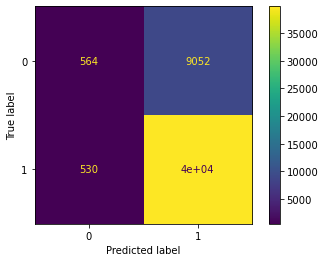

In [32]:
#get predictions 
preds = logreg.predict(X_test)

#plot confusion matrix
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm).plot();

In [34]:
print(f'Various scores:  AUROC: {roc_auc_score(y_test, preds)}, ACC_SCORE: {accuracy_score(y_test, preds)}, F1: {f1_score(y_test, preds)}')


Various scores:  AUROC: 0.5227641183737617, ACC_SCORE: 0.80836, F1: 0.8926867510359502


In [35]:
#create a list of the model classes to test
model_list = [
    #LogisticRegression(),
    #DecisionTreeClassifier(),
    #BaggingClassifier(),
    RandomForestClassifier(),
    #ExtraTreesClassifier(),
    #AdaBoostClassifier(),
    GradientBoostingClassifier()
]

In [36]:
#scale features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

#create a list to store each model's results in a dictionary
classifier_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj

    #fit the model
    model.fit(X_train_sc, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train_sc, y_train)
    results_dict['test_score'] = model.score(X_test_sc, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train_sc, y_train, cv = 5).mean()
        
    #add the dictionary to the list
    classifier_list.append(results_dict)

In [37]:
clf_results = pd.DataFrame(classifier_list)
clf_results

,model_name,train_score,test_score,cv_score
0,RandomForestClassifier(),0.999993,0.86312,0.861067
1,GradientBoostingClassifier(),0.849187,0.84690,0.848207


In [36]:
#Results before number of words and characters were added
clf_results = pd.DataFrame(classifier_list)
clf_results

,model_name,train_score,test_score,cv_score
0,LogisticRegression(),0.852340,0.85158,0.852060
1,DecisionTreeClassifier(),0.971040,0.85248,0.850940
2,BaggingClassifier(),0.965067,0.86543,0.864090
3,RandomForestClassifier(),0.971033,0.87157,0.872913
4,ExtraTreesClassifier(),0.971040,0.86230,0.861563
5,AdaBoostClassifier(),0.861270,0.86063,0.861053
6,GradientBoostingClassifier(),0.865297,0.86416,0.864963


### Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators = 300, max_features=50)

In [ ]:
rf.fit(X_train,y_train)

In [ ]:
print(rf.score(X_train, y_train), rf.score(X_test, y_test))

In [ ]:
rf = RandomForestClassifier(n_estimators = 300, max_depth=10, min_samples_leaf=2)
rf.fit(X_train,y_train)
print(rf.score(X_train, y_train), rf.score(X_test, y_test))

In [ ]:
rf = RandomForestClassifier(n_estimators = 300, max_depth=10, min_samples_leaf=3, bootstrap=True)
rf.fit(X_train,y_train)
print(rf.score(X_train, y_train), rf.score(X_test, y_test))

In [ ]:
rf = RandomForestClassifier(n_estimators = 300, max_depth=10, min_samples_leaf=3, bootstrap=False)
rf.fit(X_train,y_train)
print(rf.score(X_train, y_train), rf.score(X_test, y_test))

### Extra Trees?

In [ ]:
et = ExtraTreesClassifier(n_estimators = 300, max_depth=10, min_samples_leaf=2, bootstrap = True)
et.fit(X_train,y_train)
print(et.score(X_train, y_train), et.score(X_test, y_test))

In [ ]:
et = ExtraTreesClassifier(n_estimators = 300, max_depth=10, min_samples_leaf=2, bootstrap = False)
et.fit(X_train,y_train)
print(et.score(X_train, y_train), et.score(X_test, y_test))

### Gradient Boosting Classifier

In [ ]:
gb = GradientBoostingClassifier(n_estimators=300)
gb.fit(X_train, y_train)
print(gb.score(X_train, y_train), gb.score(X_test, y_test),  
      cross_val_score(gb, X_train, y_train, cv = 5).mean())

In [ ]:
#get predictions 
preds_gb = gb.predict(X_test)

#plot confusion matrix
cm = confusion_matrix(y_test, preds_gb)
ConfusionMatrixDisplay(cm, display_labels=['0','1','2','3']).plot();

In [ ]:
pd.DataFrame({'importance' : gb.feature_importances_, 'feature_names' : X_train.columns}).sort_values(by='importance', ascending=False).head(25)

In [ ]:
gb2 = GradientBoostingClassifier(n_estimators=500)
gb2.fit(X_train, y_train)
print(gb2.score(X_train, y_train), gb2.score(X_test, y_test),  
      cross_val_score(gb2, X_train, y_train, cv = 5).mean())

In [ ]:
gb3 = GradientBoostingClassifier(n_estimators=500, 
                        min_samples_split = 100, 
                        min_samples_leaf = 50, 
                        max_depth=8,
                        max_features='sqrt',
                        subsample=0.8)
gb3.fit(X_train, y_train)
print(gb3.score(X_train, y_train), gb3.score(X_test, y_test),  
      cross_val_score(gb3, X_train, y_train, cv = 5).mean())